# 数据挖掘-预测贷款用户是否逾期
## Task3：模型构建（2天）

------
### 1&emsp;划分数据集


 - 导入宏包

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['font.sans-serif']=[u'SimHei']
mpl.rcParams['axes.unicode_minus']=False

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.float_format',lambda x : '%.5f' % x)

 - 导入数据

In [57]:
data = pd.read_csv('./data/data_clean.csv', encoding='gbk')

 - 下采样

In [58]:
dfstatus0 = data[data.status == 0]
dfstatus1 = data[data.status == 1]
dfstatus0 = dfstatus0.sample(n=data.status.value_counts()[1], replace=True, random_state=2018)
newdata = pd.concat([dfstatus0, dfstatus1], ignore_index=False)
newdata.sort_index(inplace=True)
newdata = newdata.reset_index(drop=True)

 - 重构数据集

In [59]:
Y = newdata['status']
X = newdata.drop(['status'], axis=1)
Y.shape[0]

2226

 - 划分数据集

In [71]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2018)

------
### 2&emsp;模型构建
#### 2.1 P-R曲线

 - 生成 P-R 曲线函数

In [74]:
def PR_curve(d):
    t = np.sum(d[:, 3])
    f = d.shape[0] - t

    TP = 1
    FP = 0
    FN = t - 1

    P = [1]
    R = [1 / t]
    l = [1 - 1 / t]

    for i in range(1, d.shape[0]):
        if d[i, 3] == 1:
            TP = TP + 1
            FP = FP + 0
            FN = FN - 1

        if d[i, 3] == 0:
            TP = TP + 0
            FP = FP + 1
            FN = FN + 0

        P.append(TP / (TP + FP))
        R.append(TP / (TP + FN))
        l.append(np.abs(P[i] - R[i]))

    plt.figure()
    plt.plot(R, P)
    x = np.linspace(0, 1)
    y = np.linspace(0, 1)
    plt.plot(x, y)
    l_min = l.index(min(l))
    plt.plot(P[l_min], R[l_min], 'ro')
    print("BEC = {:.3f}".format(P[l_min]))
    print("F1 = {:.3f}".format(2 * P[l_min] * R[l_min] / (P[l_min] + R[l_min])))

 - 模型训练

逻辑回归

Test set score = 0.669
BEC = 0.658
F1 = 0.658


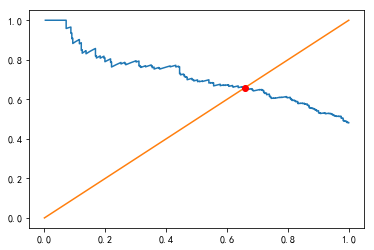

In [75]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train, y_train)
y_proba = LR.predict_proba(x_test)
y_predi = LR.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
print("Test set score = {:.3f}".format(LR.score(x_test, y_test)))
PR_curve(d)

支持向量机

Test set score = 0.591
BEC = 0.578
F1 = 0.578


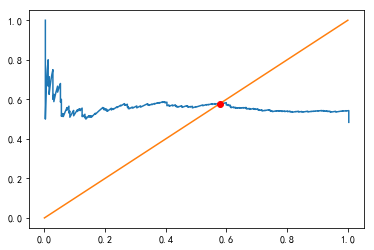

In [83]:
from sklearn import svm
SVM = svm.SVC(probability=True)
SVM.fit(x_train, y_train)
y_proba = SVM.predict_proba(x_test)
y_predi = SVM.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
print("Test set score = {:.3f}".format(SVM.score(x_test, y_test)))
PR_curve(d)

 - 决策树

Test set score = 0.627
BEC = 0.596
F1 = 0.596


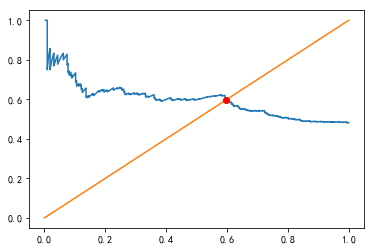

In [82]:
from sklearn import tree
DTC = tree.DecisionTreeClassifier()
DTC.fit(x_train, y_train)
y_proba = DTC.predict_proba(x_test)
y_predi = DTC.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
print("Test set score = {:.3f}".format(DTC.score(x_test, y_test)))
PR_curve(d)

#### 2.2 ROC曲线

 - 生成 ROC 曲线函数

In [86]:
def ROC_curve(d):
    t = np.sum(d[:,3])
    f = d.shape[0] - t

    TP = 1
    TN = f
    FP = 0
    FN = t-1
    

    TPR = [1/t]
    FPR = [0]
    AUC = 0

    for i in range(1, d.shape[0]):
        if d[i,3] == 1:
            TP = TP+1
            FN = FN-1

        if d[i,3] == 0:
            FP = FP+1
            TN = TN-1

        TPR.append(TP/(TP+FN))
        FPR.append(FP/(TN+FP))
        AUC = AUC+0.5*((FPR[i]-FPR[i-1])*(TPR[i]+TPR[i-1]))
    
    plt.figure()
    plt.plot(FPR,TPR)
    x = np.linspace(0,1)
    y = np.linspace(0,1)
    plt.plot(x, y, '--')
    
    print("AUC = {:.3f}".format(AUC))

 - 模型训练

随机森林

Test set score = 0.687
AUC = 0.764


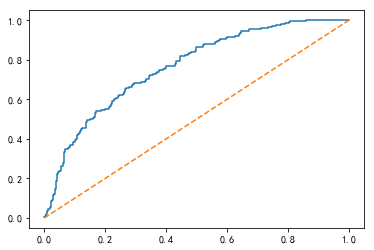

In [87]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
RFC.fit(x_train, y_train)
y_proba = RFC.predict_proba(x_test)
y_predi = RFC.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
print("Test set score = {:.3f}".format(RFC.score(x_test, y_test)))
ROC_curve(d)

XGBoost

Test set score = 0.710
AUC = 0.794


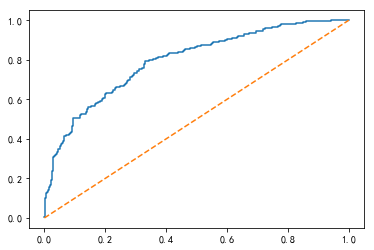

In [88]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(x_train, y_train)
y_proba = XGB.predict_proba(x_test)
y_predi = XGB.predict(x_test)
d = np.vstack((y_proba.T[0].T, y_proba.T[1].T, y_predi, y_test.T)).T
d = d[d[:,0].argsort()]
print("Test set score = {:.3f}".format(XGB.score(x_test, y_test)))
ROC_curve(d)